In [123]:
%reset -f

import sys
sys.path.append('../code')

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib
from hampel import hampel
import utility

from scipy.spatial.transform import Rotation as R

import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']
plt.rcParams['text.usetex'] = False
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'

%matplotlib inline

from filemanager import FileManager 
from plot_utility import mathify_ticklabels
import direct_trajectory_simulator

import utility


## Load data

In [124]:
# Load data
# fpath = r'C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5\NEW_2022-07-27-22-07-46.hdf'
# test = pd.read_hdf(fpath)

root = r'C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5'

FileSelect = FileManager() # create FileManager instance
FileSelect.Select(root) # open file selection GUI in root folder

f = h5py.File(FileSelect.files[0], 'r')

In [125]:
# Get the data
intrp = f['intrp'] # work with interpolated data
raw = f['raw'] # work with raw data
keys = list(raw.keys())
print(keys)
# list(data['imu'])

['agf', 'att', 'avf', 'gps', 'gps_sync', 'imu', 'obtrs', 'opt', 'rc', 'rtk_pos', 'rtk_vel', 'rtk_yaw', 'utc_sync', 'vel', 'vo']


## Process data

In [319]:
# Interpolated time
time = np.swapaxes(np.array(intrp['time']), 0, 1)

# GPS position
gps = intrp['gps']
gps_x = np.swapaxes(np.array(gps['x']), 0, 1)
gps_y = np.swapaxes(np.array(gps['y']), 0, 1)
gps_z = np.swapaxes(np.array(gps['z']), 0, 1)

# RTK GPS position
rtk_pos = intrp['rtk_pos']
rtk_x = np.swapaxes(np.array(rtk_pos['x']), 0, 1)
rtk_y = np.swapaxes(np.array(rtk_pos['y']), 0, 1)
rtk_z = np.swapaxes(np.array(rtk_pos['z']), 0, 1)

# IMU orientation
imu = intrp['imu']
# print(imu.keys())
imu_yaw_unwrap = np.swapaxes(np.array(imu['yaw_unwrap']), 0, 1)
imu_yaw = imu_yaw % (2*np.pi)

# Onboard trisonica wind sensor
obtrs = intrp['obtrs']
print(obtrs.keys())
air_speed_dir = np.swapaxes(np.array(obtrs['dir_unwrap']), 0, 1)

air_speed_mag = np.squeeze(np.swapaxes(np.array(obtrs['speed']), 0, 1))
air_speed_mag = hampel(pd.Series(air_speed_mag), window_size=5, n=3, imputation=True)

air_speed_mag2 = np.squeeze(np.swapaxes(np.array(obtrs['speed2']), 0, 1))
air_speed_mag2 = hampel(pd.Series(air_speed_mag2), window_size=5, n=3, imputation=True)

air_speed_x = np.squeeze(np.swapaxes(np.array(obtrs['westeast']), 0, 1))
air_speed_x = hampel(pd.Series(air_speed_x), window_size=5, n=3, imputation=True)

air_speed_y = np.squeeze(np.swapaxes(np.array(obtrs['northsouth']), 0, 1))
air_speed_y = hampel(pd.Series(air_speed_y), window_size=5, n=3, imputation=True)

air_speed_z = np.squeeze(np.swapaxes(np.array(obtrs['updown']), 0, 1))
air_speed_z = hampel(pd.Series(air_speed_z), window_size=5, n=3, imputation=True)


<KeysViewHDF5 ['dir', 'dir_unwrap', 'northsouth', 'pitch', 'roll', 'speed', 'speed2', 'temp', 'updown', 'westeast']>


## Store processed data in new dataframe

In [206]:
alldata = np.concatenate((time, 1000*gps_x, 1000*gps_y, imu_yaw), axis=1)
names = ['t', 'xpos', 'ypos', 'phi']
   
# Creating dataframe
df = pd.DataFrame(data = alldata, 
                  columns = names)
# print(df)

## Plot

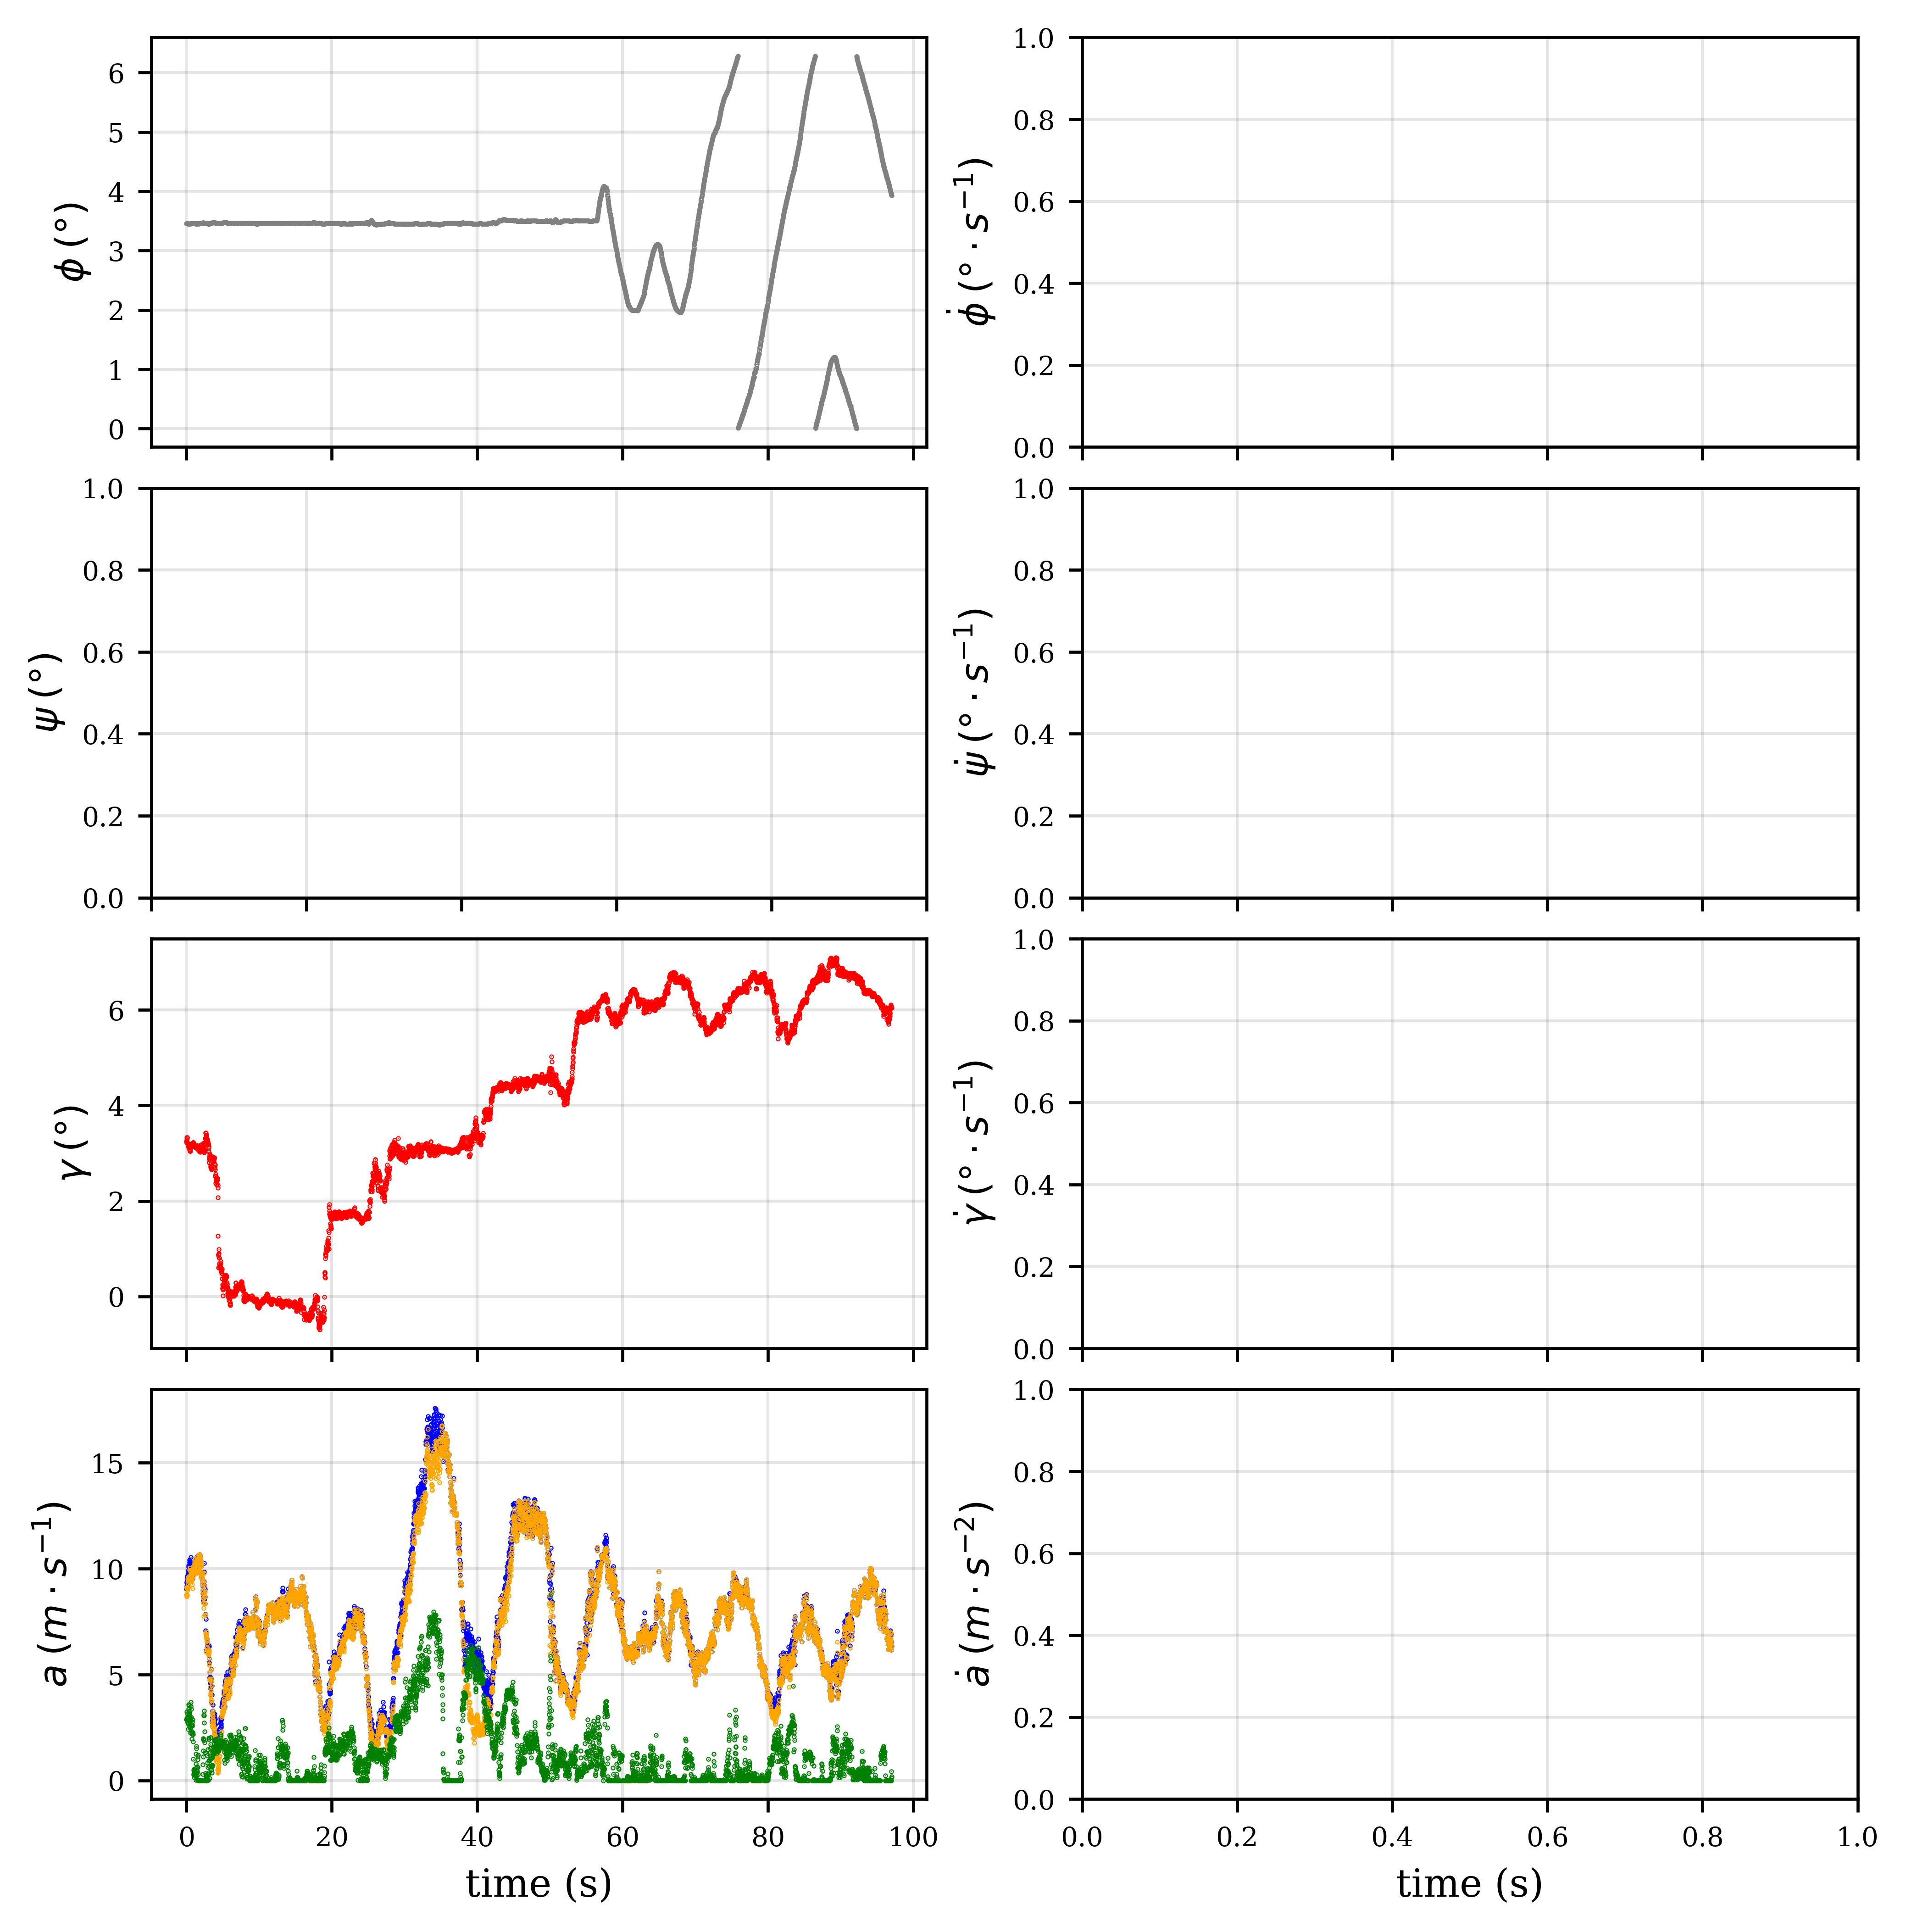

In [320]:
# fig = plt.figure(figsize=(8,6))
# fig, axs = plt.subplots(2, 2)

fig, ax = plt.subplots(4, 2, figsize=(8,8), dpi=600)
mksz = 0.5;
# Phi
ax[0,0].plot(time, imu_yaw, color='gray',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

# Phi
ax[2,0].plot(time, air_speed_dir, color='red',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ax[3,0].plot(time, air_speed_mag, color='blue',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ax[3,0].plot(time, air_speed_mag2, color='orange',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ax[3,0].plot(time, np.abs(air_speed_z), color='green',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ylabels = ['$\phi \:(\degree)$', '$\dot{\phi} \:(\degree \cdot s^{-1})$',
           '$\psi \:(\degree)$', '$\dot{\psi} \:(\degree \cdot s^{-1})$',
           '$\gamma \:(\degree)$', '$\dot{\gamma} \:(\degree \cdot s^{-1})$',
           r'$a \:(m \cdot s^{-1})$', '$\dot{a} \:(m \cdot s^{-2})$']
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    
    if p < 7:
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1])
    if p > 6:
        a.set_xlabel('time (s)')
        
    p = p + 1

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plt.show()

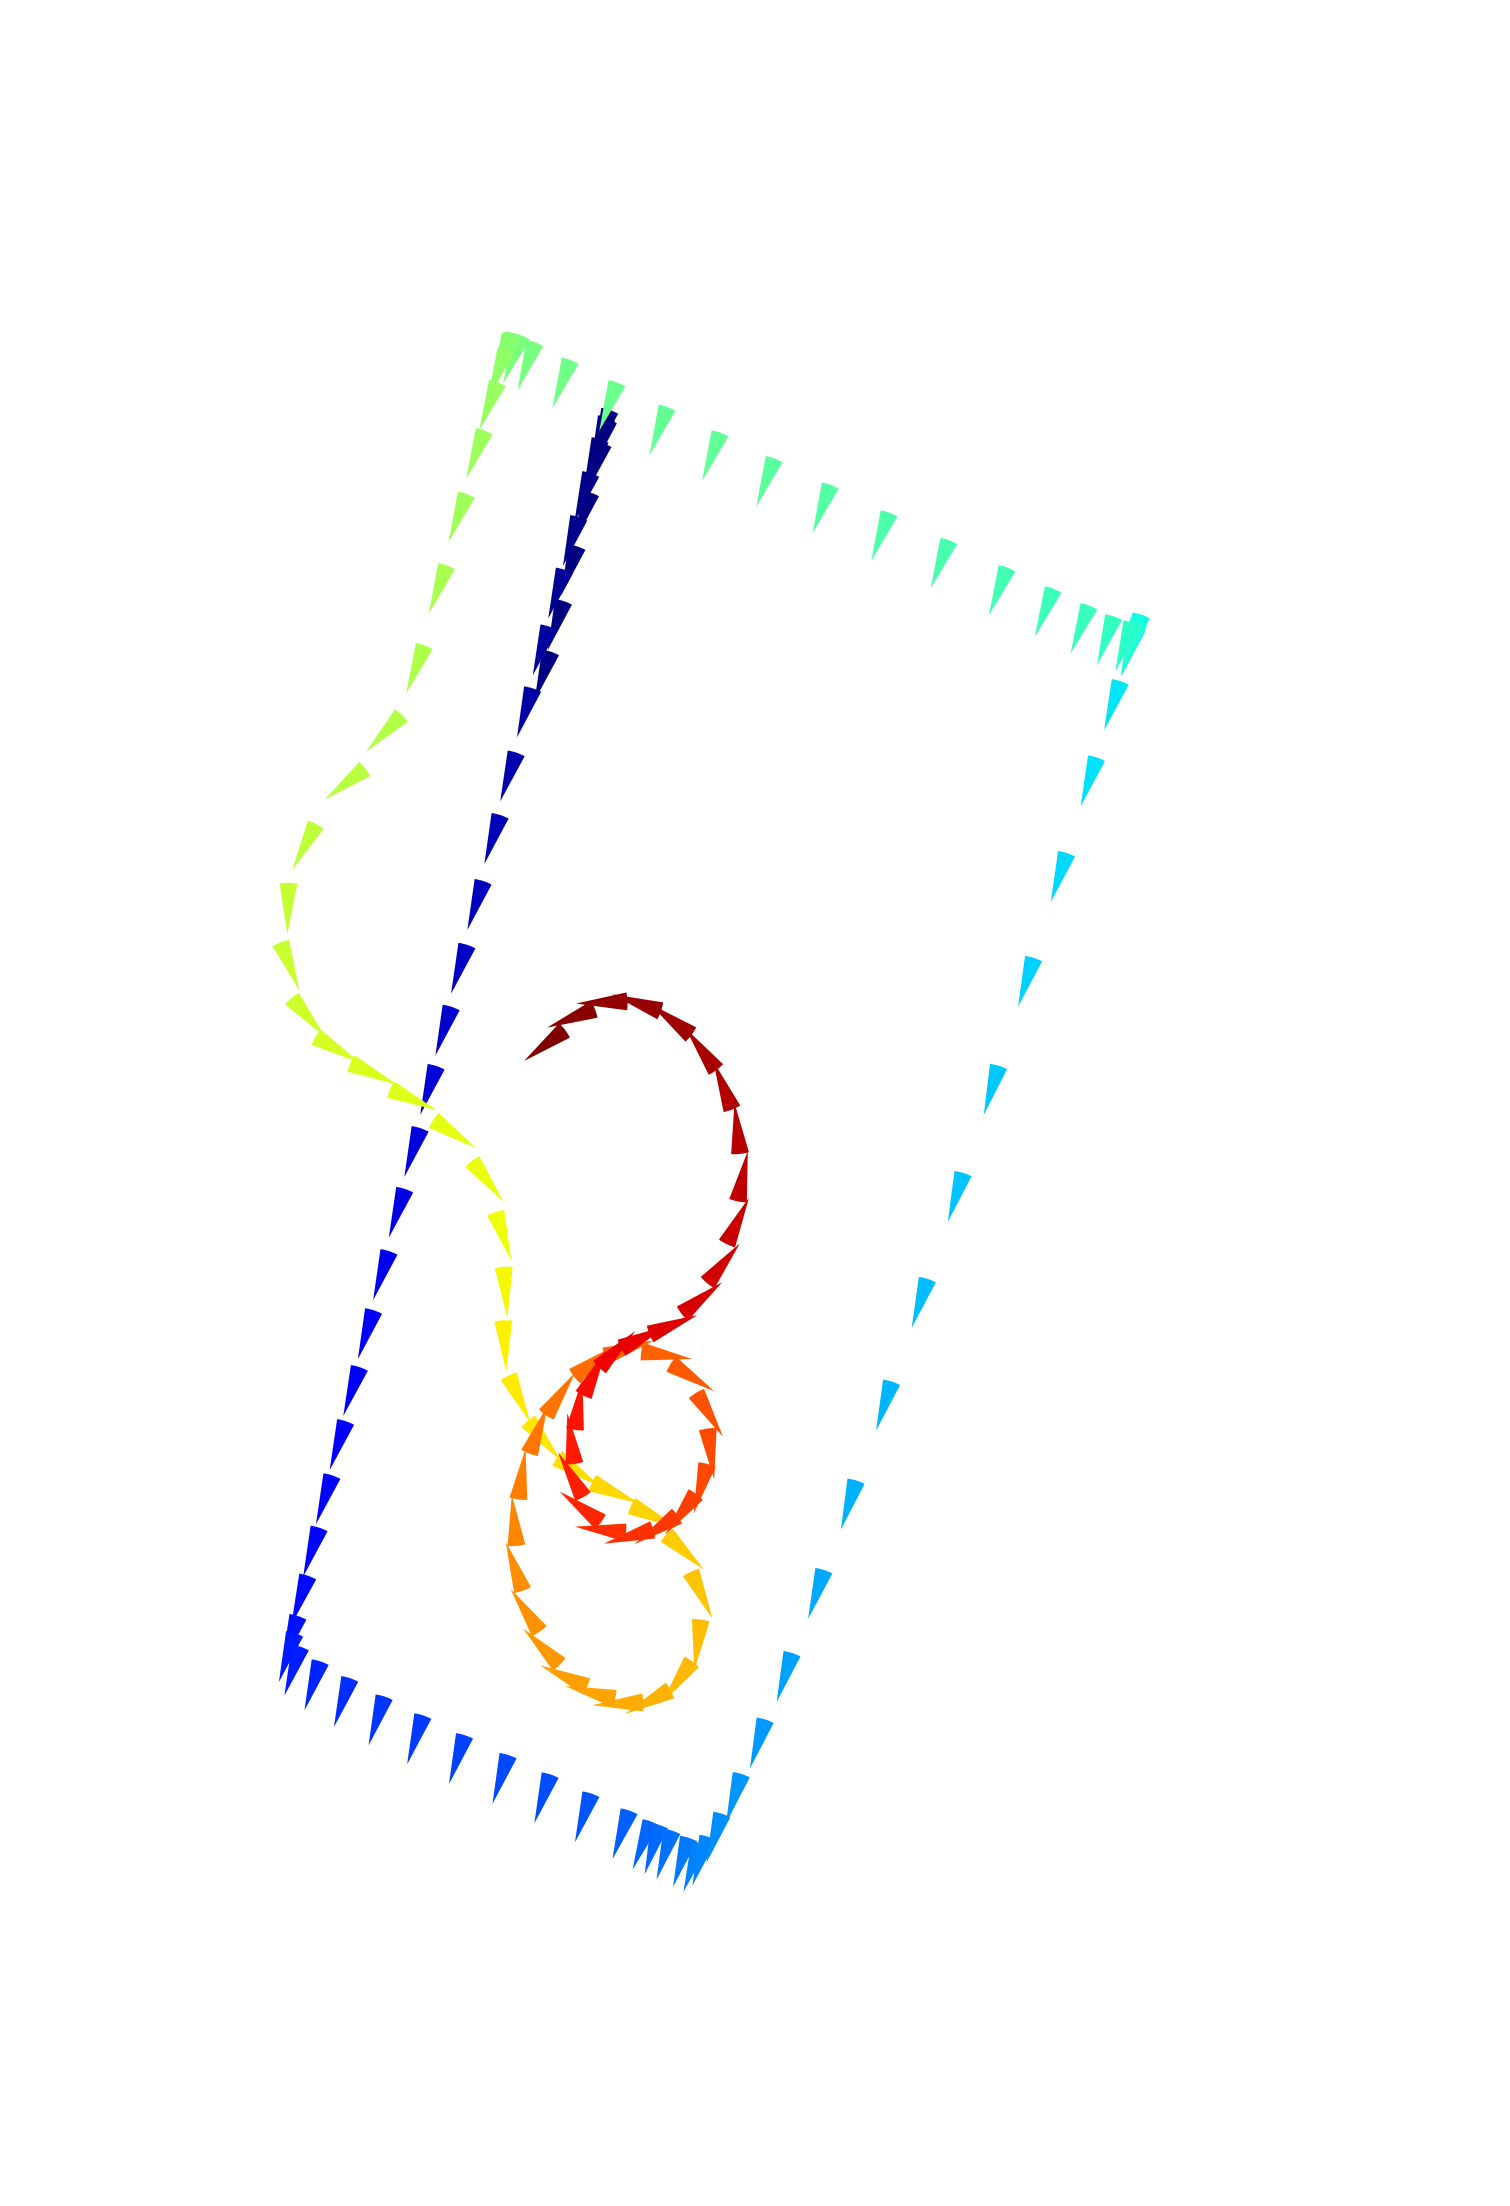

In [239]:
plotdata = df.copy()
plotdata['phi'] = -plotdata['phi'].values + np.deg2rad(90)
size_radius = 0.15*np.mean(np.abs(np.hstack((df['xpos'] , df['ypos']))))

fig = plt.figure(figsize=(4,4), dpi=600)
ax = fig.add_subplot(111)
utility.plot_trajec(plotdata, ax=ax,
                    size_radius=size_radius,
                    nskip=30,
                    show_wind_quivers=False,
                    colormap='jet')
plt.show()

In [78]:
noise_type = 'normal'
noise_parameters = [0, 0.1]  # mean and std

# time step size and time series length in TIME
dt = 0.01
timeseries_length = 4
# simulate data

x, x_truth, dxdt_truth, _ = simulate.pi_control(dt=dt, timeseries_length=timeseries_length, 
                                                noise_type=noise_type, noise_parameters=noise_parameters)

RMS error in velocity:  6.820305856536254


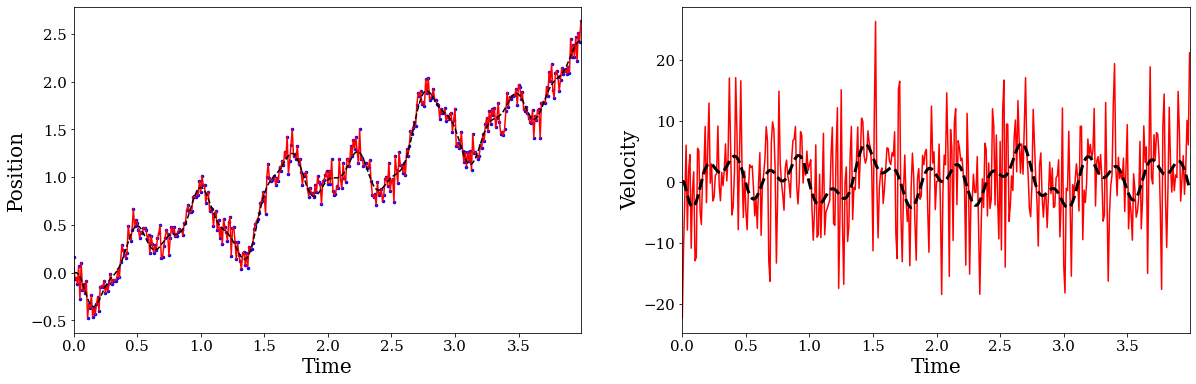

In [79]:
x_hat, dxdt_hat = pynumdiff.finite_difference.first_order(x, dt)
evaluate.plot(x, dt, x_hat, dxdt_hat, x_truth, dxdt_truth)